# Setup #

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import os
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import DataLoader
from torch.utils.data import ConcatDataset
from pathlib import Path as Path
from dataset import *
from utils import *
from cpt import *
from functools import partial
from tqdm import tqdm
# import wandb
tqdm = partial(tqdm, position=0, leave=True)
import matplotlib.pylab as pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

USE_GPU = True
dtype = torch.float32 # we will be using float
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

from seaborn import heatmap
import seaborn as sns
sns.set_style("white")
sns.axes_style("white")

using device: cuda


{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'grid.color': '.8',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

# Load model (trained on ttH) #

In [4]:
### DON'T CHANGE ###
max_num_output = 2 # assert that there are at most ${max_num_output} tops
base_dir = './trained'
arch = 'CovariantTopFormer'
model_params = {
    'geometric': True,
    'break_eta_covariance': False,
    'in_dim': 9,
    'out_dim': 4,
    'max_num_output': max_num_output,
    'hidden_dim': 256,
    'num_convs': (6, 6),
    'heads': 4,
    'mass': 173,
    'match_scale_factor': torch.FloatTensor([0, 1, 1, 0]), # used for matching dR = (dy, dphi)    
    'p_norm': 2, # used in matching and loss
    'beta': 0.8, # loss weight for predicting number of tops
    'dropout': 0.,
    'schedule_lr': False,
    'use_gpu': USE_GPU,
    'uniform_attention': False,
}
tag = '0901_ttH'
output_dir = f"{arch}_{model_params['num_convs']}_{model_params['hidden_dim']}_{tag}"
output_dir = os.path.join(base_dir, output_dir)
model_params['output_dir'] = output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model = eval(arch)(**model_params).to(device)
model.load('min_val_loss_model.pt')
### DON'T CHANGE ###

Using Lamb optimizer with lr=0.0001
Loaded model from ./trained/CovariantTopFormer_(6, 6)_256_0901_ttH/saved_models/min_val_loss_model.pt
Model has 12M parameters
Loaded model from ./trained/CovariantTopFormer_(6, 6)_256_0901_ttH/saved_models/min_val_loss_model.pt


True

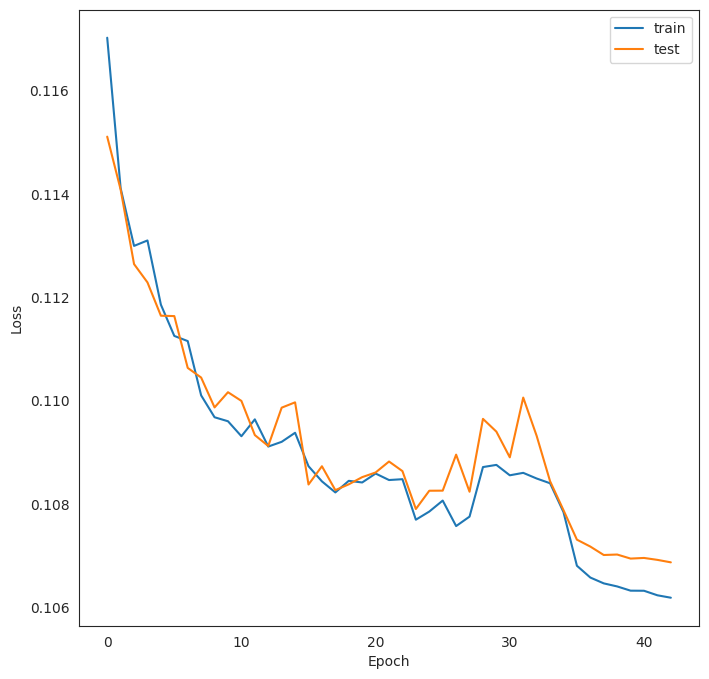

In [16]:
plt.plot(model.history['train_loss'], label='train')
plt.plot(model.history['test_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Load dataset (ttH, ttW, or ttbar) #
(the model is trained on ttH, so the last two test generalization to different processes)

In [19]:
### DON'T CHANGE ###
max_num_output = 2 # assert that there are at most two tops
detector_x = True # use cartesian coordinates for input
detector_y = True # use cartesian coordinates for output
to_torch_test = get_to_torch(max_num_output, detector_x=detector_x, detector_y=detector_y, test=True) # reformat the data for torch
### DON'T CHANGE ###

# Pick a dataset by uncommenting it

# ttH
dataset_names = ['data/final/ttH']
Ds = [ConcatDataset([LMDBDataset(f'{dataset_name}/data_{i}', transform=to_torch_test, use_cache=False, readahead=False) for i in range(0, 1)]) for dataset_name in dataset_names]
Ds = [split_dataset(D, name=ds_name, max_train_event=None, max_test_event=None) for D, ds_name in zip(Ds, dataset_names)]
D_train = ConcatDataset([D[0] for D in Ds])
D_val = ConcatDataset([D[1] for D in Ds])
D_test = ConcatDataset([D[2] for D in Ds])

# # ttW
# dataset_names = ['data/final/ttW']
# D_test = LMDBDataset(f'{dataset_names[0]}/data_0', transform=to_torch_test, use_cache=True, readahead=False)

# # ttbar
# dataset_names = ['data/final/ttbar']
# D_test = LMDBDataset(f'{dataset_names[0]}/data_0', transform=to_torch_test, use_cache=True, readahead=False)

Padding up to 2 outputs
X: (pT, y, phi, m)
Y: (pT, y, phi, m)


# Run inference #

In [67]:
# Can skip to next cell to use precomputed test results
batch_size = 1024
max_num_batch = 100 # set a large value (1e7) to run on all test data
version_name = "YOUR_VERSION_NAME" # choose a name for saving result to disk

test_loader = DataLoader(D_test, batch_size, num_workers=4, prefetch_factor=1, follow_batch=['x_in']) if D_test else None
test_result = model.run_inference(test_loader, max_num_batch=max_num_batch, force_correct_num_pred=True, version=version_name)

  0%|          | 0/1126 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [57]:
tm = torch.tensor(test_result['truth_matched'])
am = torch.tensor(test_result['attention_matched'])
nb = torch.tensor(test_result['N_bj']).view(-1, 1).repeat(1, 2).reshape(-1)
twob = nb == 2
am[(tm * twob) == 1].float().mean()

tensor(0.6444)

# Make table and plots #

In [68]:
from make_stats import run as make_plots_and_tables
### DON'T CHANGE ###
bins = 2 # bins - 1 = actual number of bins...
entries_per_bin = 100000000 # for binning the result in phase space. set a large number to skip this.
### DON'T CHANGE ###

# You can choose "version_name" from {ttH_final, ttW_final, ttbar_final} to use precomputed test results
# Note the attention matching computed in those files does not restrict to jets, unlike the current implementation
version_name = 'ttH_final' 
test_result = torch.load(f'{output_dir}/test_result_{version_name}.pt')
make_plots_and_tables(test_result, f'{output_dir}/test_result_{version_name}', max_num_output, bins, entries_per_bin) 
# once the above run, can find a summary table named result.csv inside the output directory (2nd arg).

Applied trigger cut
Applied trigger cut
Applied trigger cut
Applied trigger cut
dataset: ttH
cut: Inclusive


  0%|          | 0/1 [00:00<?, ?it/s]/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/shikai_q/Covariant-Particle-Transformer/make_stats.py:347: RuntimeWarning: invalid value encountered in divide
  for s in stats_array:


cut: Truth-matched


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/histograms.py:883: Runtim

cut: Not truth-matched


  0%|          | 0/1 [00:00<?, ?it/s]/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/shikai_q/Covariant-Particle-Transformer/make_stats.py:347: RuntimeWarning: invalid value encountered in divide
  for s in stats_array:
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/histogr

cut: Attention-matched


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


cut: Hadronic


  0%|          | 0/1 [00:00<?, ?it/s]/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/shikai_q/Covariant-Particle-Transformer/make_stats.py:347: RuntimeWarning: invalid value encountered in divide
  for s in stats_array:


cut: Leptonic


  0%|          | 0/1 [00:00<?, ?it/s]/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/shikai_q/Covariant-Particle-Transformer/make_stats.py:347: RuntimeWarning: invalid value encountered in divide
  for s in stats_array:
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/shikai_q/miniconda3/envs/cpt/lib/python3.9/site-packages/numpy/lib/histogr

Applied trigger cut
Applied trigger cut
Applied trigger cut
Applied trigger cut
Applied trigger cut
Applied trigger cut
Applied trigger cut


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>